# 프로젝트: CutMix 또는 Mixup 비교실험

### 1. Augmentation을 적용한 데이터셋 만들기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

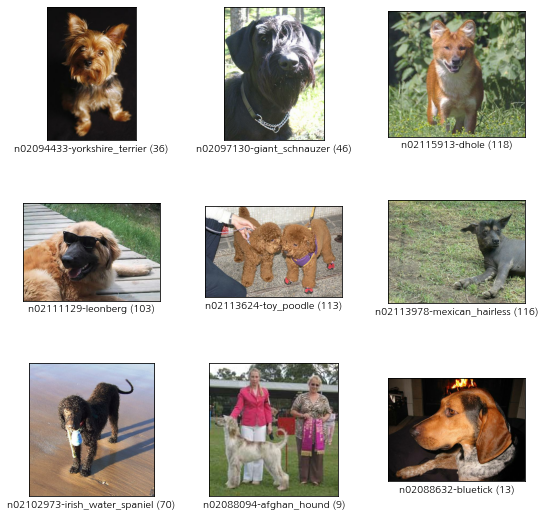

In [4]:
fig = tfds.show_examples(ds_train, ds_info)

In [5]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [6]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

#### Cutmix Augmentation

In [7]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(image_size_x, x+width//2)
    yb = tf.math.minimum(image_size_y, y+width//2)
    
    return xa, ya, xb, yb

In [8]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [9]:
# mix two labels
def mix_2_label(image_a, image_b, label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa)*(yb-ya)
    total_area = image_size_x*image_size_y
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b #
    return mixed_label

In [10]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(image_a, image_b, label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

#### Mixup Augmentation

In [11]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

In [12]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [13]:
def onehot(image, label, num_classes=120):

    onehot_label = tf.one_hot(label, num_classes)

    return image, onehot_label

In [14]:

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )

    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    
    if not with_cutmix and not with_mixup:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### 2. 모델 만들기


In [15]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [16]:

aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [17]:

cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [18]:

mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [19]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

### 3. 모델 훈련하기

In [20]:
tf.random.set_seed(2020)

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 147s 163ms/step - loss: 3.1710 - accuracy: 0.2812 - val_loss: 3.4520 - val_accuracy: 0.1952
Epoch 2/20
750/750 [==============================] - 125s 167ms/step - loss: 0.9582 - accuracy: 0.7358 - val_loss: 1.2506 - val_accuracy: 0.6339
Epoch 3/20
750/750 [==============================] - 126s 167ms/step - loss: 0.3767 - accuracy: 0.9022 - val_loss: 0.9433 - val_accuracy: 0.7189
Epoch 4/20
750/750 [==============================] - 118s 157ms/step - loss: 0.1450 - accuracy: 0.9738 - val_loss: 0.9146 - val_accuracy: 0.7353
Epoch 5/20
750/750 [==============================] - 115s 154ms/step - loss: 0.0622 - accuracy: 0.9942 - val_loss: 0.9006 - val_accuracy: 0.7466
Epoch 6/20
750/750 [==============================] - 115s 154ms/step - loss: 0.0330 - accuracy: 0.9978 - val_loss: 0.9172 - val_accuracy: 0.7457
Epoch 7/20
750/750 [==============================] - 115s 154ms/step - loss: 0.0201 - accuracy: 0.9978 - val_loss: 0.9006 -

In [21]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 120s 154ms/step - loss: 3.2192 - accuracy: 0.2752 - val_loss: 3.0810 - val_accuracy: 0.2533
Epoch 2/20
750/750 [==============================] - 115s 154ms/step - loss: 1.0957 - accuracy: 0.6820 - val_loss: 1.2515 - val_accuracy: 0.6445
Epoch 3/20
750/750 [==============================] - 115s 154ms/step - loss: 0.6146 - accuracy: 0.8221 - val_loss: 1.1697 - val_accuracy: 0.6665
Epoch 4/20
750/750 [==============================] - 115s 154ms/step - loss: 0.3669 - accuracy: 0.9035 - val_loss: 1.1434 - val_accuracy: 0.6832
Epoch 5/20
750/750 [==============================] - 115s 154ms/step - loss: 0.1954 - accuracy: 0.9566 - val_loss: 1.1117 - val_accuracy: 0.6899
Epoch 6/20
750/750 [==============================] - 115s 154ms/step - loss: 0.1332 - accuracy: 0.9722 - val_loss: 0.9830 - val_accuracy: 0.7263
Epoch 7/20
750/750 [==============================] - 115s 154ms/step - loss: 0.0889 - accuracy: 0.9856 - val_loss: 1.0330 -

In [22]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = aug_resnet50.fit(
    ds_train_cutmix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 131s 170ms/step - loss: 2.4209 - accuracy: 0.6432 - val_loss: 1.3293 - val_accuracy: 0.6469
Epoch 2/20
750/750 [==============================] - 128s 170ms/step - loss: 2.2108 - accuracy: 0.6829 - val_loss: 1.3709 - val_accuracy: 0.6438
Epoch 3/20
750/750 [==============================] - 127s 170ms/step - loss: 2.1115 - accuracy: 0.7046 - val_loss: 1.3201 - val_accuracy: 0.6575
Epoch 4/20
750/750 [==============================] - 117s 156ms/step - loss: 2.0188 - accuracy: 0.7362 - val_loss: 1.2274 - val_accuracy: 0.6778
Epoch 5/20
750/750 [==============================] - 117s 156ms/step - loss: 1.9682 - accuracy: 0.7459 - val_loss: 1.3894 - val_accuracy: 0.6374
Epoch 6/20
750/750 [==============================] - 117s 156ms/step - loss: 1.9163 - accuracy: 0.7513 - val_loss: 1.2933 - val_accuracy: 0.6779
Epoch 7/20
750/750 [==============================] - 117s 156ms/step - loss: 1.8576 - accuracy: 0.7661 - val_loss: 1.3366 -

In [23]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = aug_resnet50.fit(
    ds_train_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 114s 150ms/step - loss: 1.8911 - accuracy: 0.8295 - val_loss: 1.5003 - val_accuracy: 0.6700
Epoch 2/20
750/750 [==============================] - 112s 150ms/step - loss: 1.8108 - accuracy: 0.8391 - val_loss: 1.4785 - val_accuracy: 0.6688
Epoch 3/20
750/750 [==============================] - 125s 167ms/step - loss: 1.8055 - accuracy: 0.8483 - val_loss: 1.5903 - val_accuracy: 0.6461
Epoch 4/20
750/750 [==============================] - 122s 163ms/step - loss: 1.8026 - accuracy: 0.8505 - val_loss: 1.5238 - val_accuracy: 0.6447
Epoch 5/20
750/750 [==============================] - 129s 172ms/step - loss: 1.7358 - accuracy: 0.8618 - val_loss: 1.4004 - val_accuracy: 0.6777
Epoch 6/20
750/750 [==============================] - 128s 171ms/step - loss: 1.7354 - accuracy: 0.8537 - val_loss: 1.4341 - val_accuracy: 0.6697
Epoch 7/20
750/750 [==============================] - 125s 167ms/step - loss: 1.7223 - accuracy: 0.8626 - val_loss: 1.4145 -

### 4. 훈련 과정 시각화하기

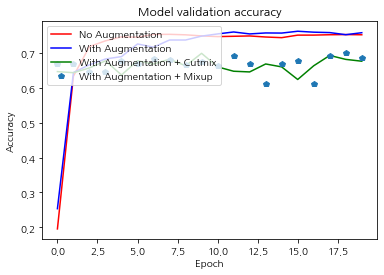

In [24]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'p')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Augmentation + Cutmix', 'With Augmentation + Mixup'], loc='upper left')
plt.show()

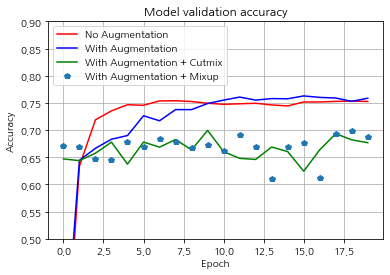

In [25]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'p')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Augmentation + Cutmix', 'With Augmentation + Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.90)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

# 프로젝트를 마치며...